In [2]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [3]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
photo_img = []
path = 'D:/archive (1)/photos/photos/'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):       
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        photo_img.append(img_to_array(img))


sketch_img = []
path = 'D:/archive (1)/sketches/sketches/'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        sketch_img.append(img_to_array(img))

  0%|          | 0/1504 [00:00<?, ?it/s]

100%|██████████| 1504/1504 [00:20<00:00, 72.69it/s]


In [4]:
photo_dataset=tf.data.Dataset.from_tensor_slices(np.array(photo_img[:1200])).batch(64)
sketch_dataset=tf.data.Dataset.from_tensor_slices(np.array(sketch_img[:1200])).batch(64)

photo_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(photo_img[1200:])).batch(8)
sketch_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(sketch_img[1200:])).batch(8)

In [5]:
example_photo = next(iter(photo_dataset))
example_sketch = next(iter(sketch_dataset))



In [5]:
def plot_images(a = 4):
    
    for i in range(a):
        plt.figure(figsize = (10,10))
        plt.subplot(121)
        plt.title('photo')
        plt.imshow(example_photo[i] )

        plt.subplot(122)
        plt.title('sketch')
        plt.imshow(example_sketch[i])
        plt.show()

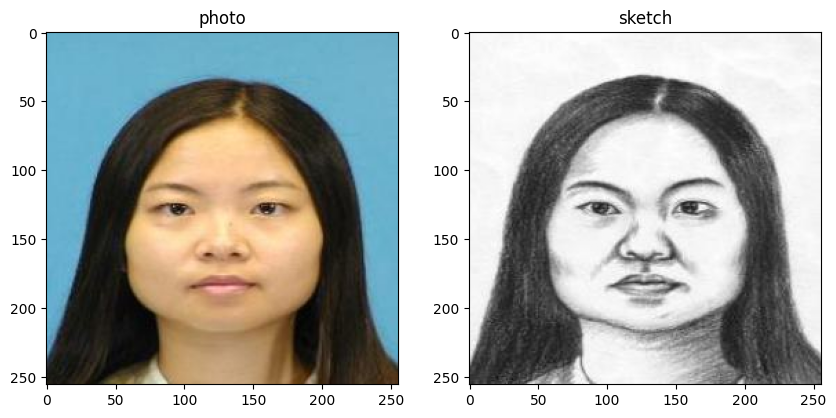

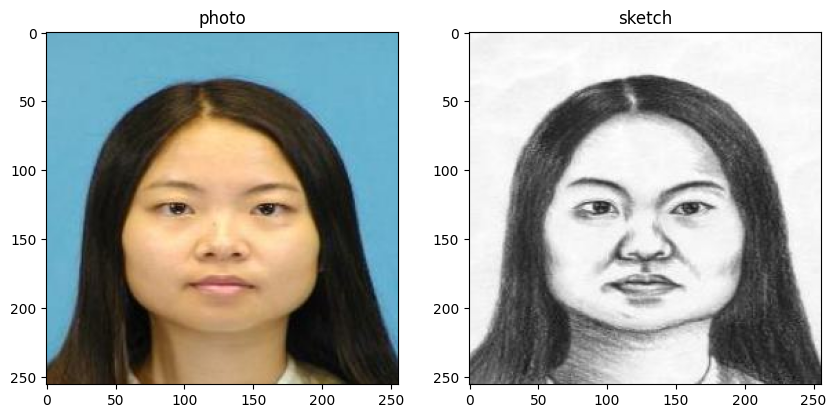

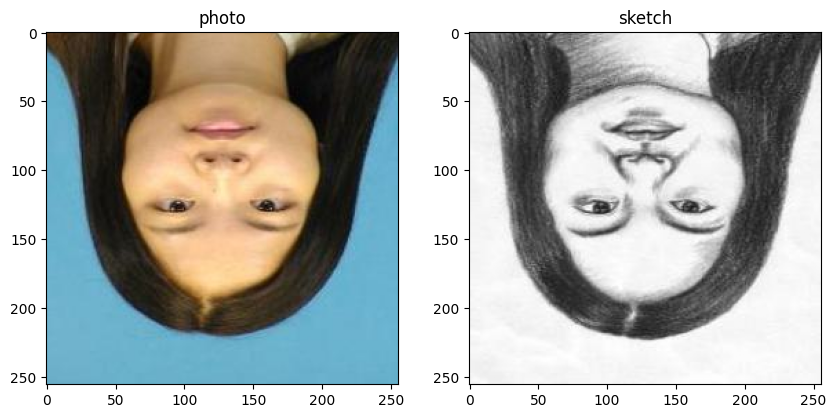

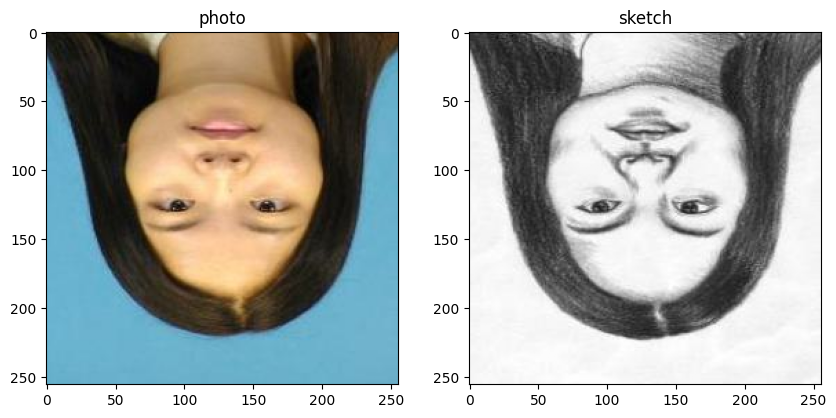

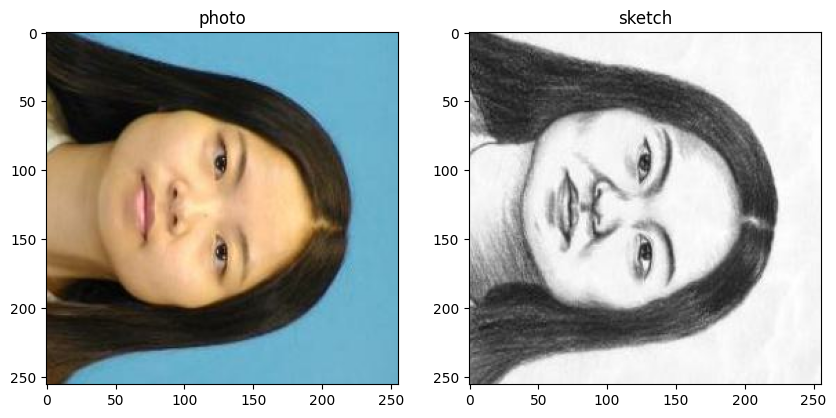

In [6]:
plot_images(5)

In [7]:
def downsample(filters, size, apply_batchnorm=True):
  
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result  

In [8]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [9]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image') # 
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image') #


  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [12]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [7]:
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val = 1)
def train_step(input_image, target, epoch):
    # Resize the input images to match the expected shape of the model
    input_image_resized = tf.image.resize(input_image, [256, 256])
    # Resize the target images to match the expected shape of the model
    target_resized = tf.image.resize(target, [256, 256])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image_resized, training=True)

        disc_real_output = discriminator([input_image_resized, target_resized], training=True)
        disc_generated_output = discriminator([input_image_resized, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target_resized)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
        generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
        
        ssim_ = ssim(gen_output, target_resized)
        
        print("Epoch:", epoch, "Generator Loss:", gen_total_loss.numpy(), "Discriminator Loss:", disc_loss.numpy(), "SSIM:", ssim_.numpy().mean())
        
        return gen_total_loss.numpy(), disc_loss.numpy(), ssim_.numpy().mean()




def test_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
        ssim_ = ssim(gen_output,target)
        return gen_total_loss.numpy(), disc_loss.numpy(), ssim_.numpy().mean()

In [14]:
import time
def fit(train_ds, test_ds, epochs):
    generator_loss = []
    discriminator_loss = []
    ssim_values = []
    generator_loss_val = []
    discriminator_loss_val = []
    ssim_values_val = []

    for epoch in range(epochs):
        start = time.time()

        print("Epoch: ", epoch+1)
        g_l = 0
        d_l = 0
        ssim_ = 0
        g_l_t = 0 
        d_l_t = 0 
        ssim_t = 0
        # Train
        for (input_image, target),(input_image_t, target_t) in zip(train_ds, test_ds):
            g_l, d_l, ssim_ = train_step(input_image, target, epoch)
            g_l_t, d_l_t, ssim_t = test_step(input_image_t, target_t, epoch)

        generator_loss.append(g_l)
        discriminator_loss.append(d_l)
        ssim_values.append(ssim_)
        generator_loss_val.append(g_l_t)
        discriminator_loss_val.append(d_l_t)
        ssim_values_val.append(ssim_)

        print("Generator loss: ", g_l,"Discriminator loss: ", d_l, 'SSIM: ', ssim_,"Generator loss val: ", g_l_t,"Discriminator loss val: ", d_l_t, 'SSIM val: ', ssim_t)
        print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))


In [15]:
def generate_images(model, test_input, tar):
    # Resize the test input to match the expected shape of the model
    test_input_resized = tf.image.resize(test_input, [256, 256])
    
    # Generate predictions
    prediction = model(test_input_resized, training=True)
    
    # Plot the images
    plt.figure(figsize=(15,15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values between [0, 1] to plot it
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


In [16]:
fit(tf.data.Dataset.zip((sketch_dataset, photo_dataset)),tf.data.Dataset.zip((sketch_dataset_t, photo_dataset_t)),
    epochs = 20)

Epoch:  1
Epoch: 0 Generator Loss: 69.760925 Discriminator Loss: 1.6817025 SSIM: -0.0026469403
Epoch: 0 Generator Loss: 58.63977 Discriminator Loss: 3.6600404 SSIM: -0.0043322975
Epoch: 0 Generator Loss: 61.875786 Discriminator Loss: 1.5026966 SSIM: -0.0021279033
Epoch: 0 Generator Loss: 54.678104 Discriminator Loss: 1.7978308 SSIM: -0.00014895931
Epoch: 0 Generator Loss: 49.927685 Discriminator Loss: 1.3143133 SSIM: 0.0037926724
Epoch: 0 Generator Loss: 50.503746 Discriminator Loss: 1.275135 SSIM: 0.008909581
Epoch: 0 Generator Loss: 45.005077 Discriminator Loss: 1.1865922 SSIM: 0.015248986
Epoch: 0 Generator Loss: 44.705566 Discriminator Loss: 1.1471334 SSIM: 0.019222617
Epoch: 0 Generator Loss: 39.32183 Discriminator Loss: 1.1025372 SSIM: 0.025943158
Epoch: 0 Generator Loss: 29.497908 Discriminator Loss: 1.084878 SSIM: 0.03752183
Epoch: 0 Generator Loss: 23.8826 Discriminator Loss: 1.1054491 SSIM: 0.047411185
Epoch: 0 Generator Loss: 27.24684 Discriminator Loss: 1.0889844 SSIM: 0.05

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


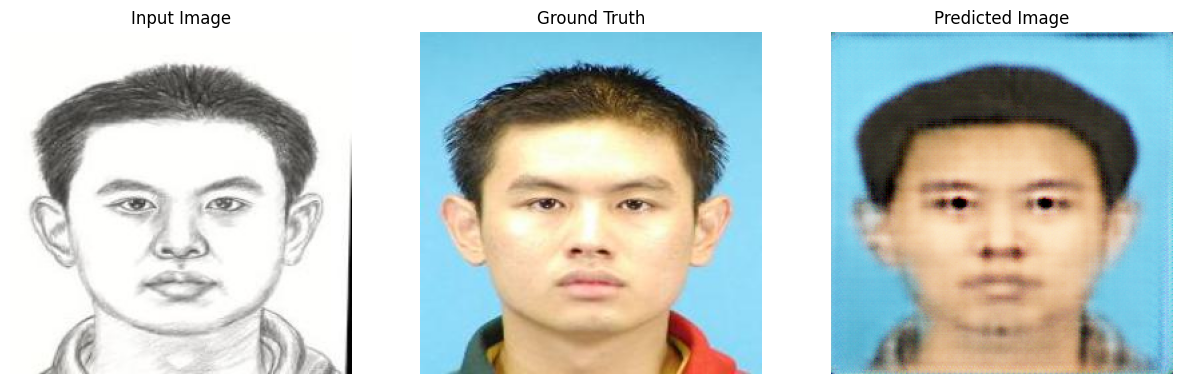

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


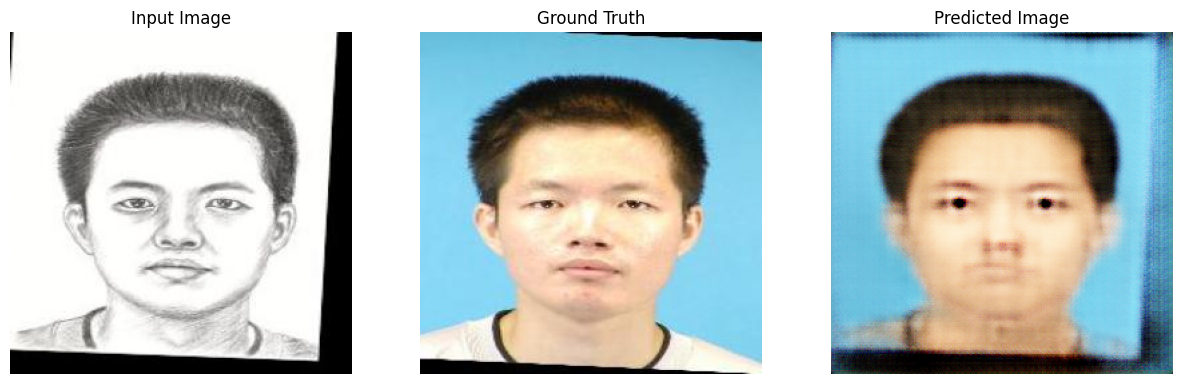

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


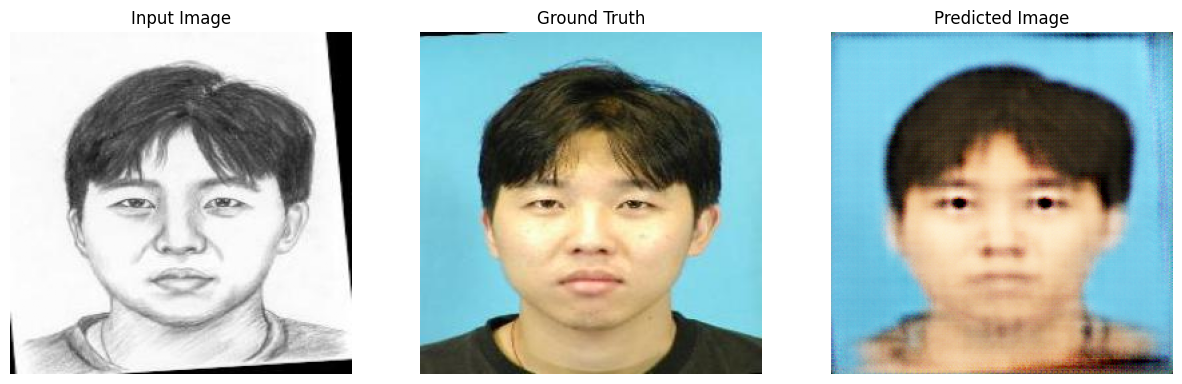

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


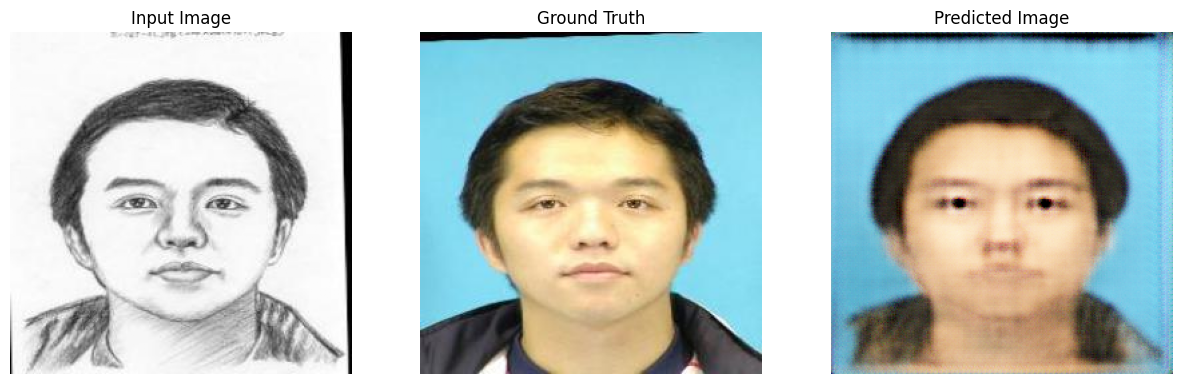

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


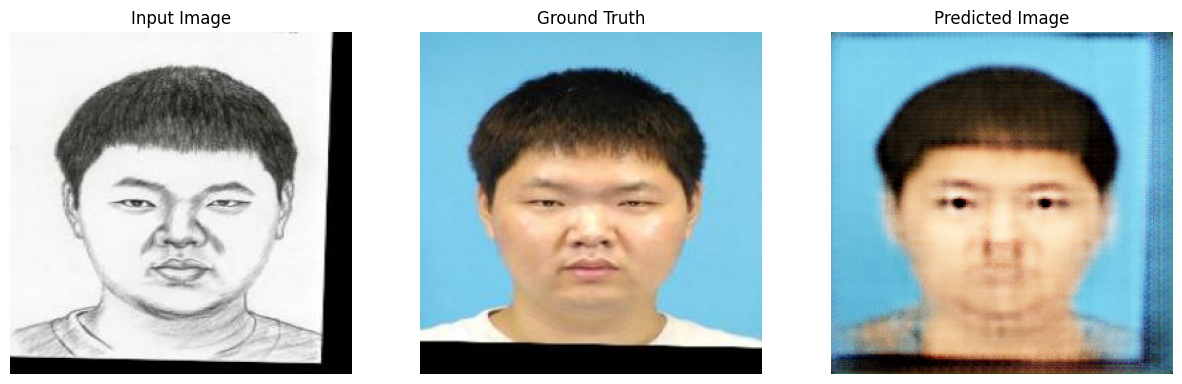

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


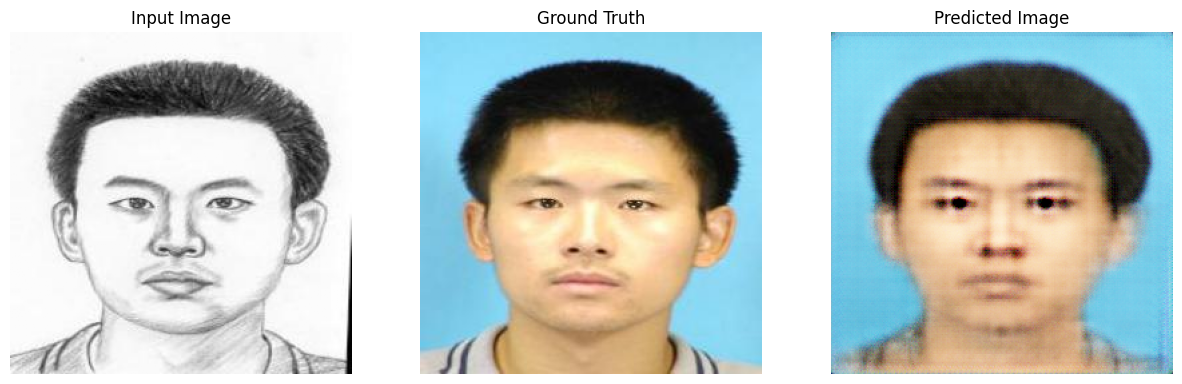

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


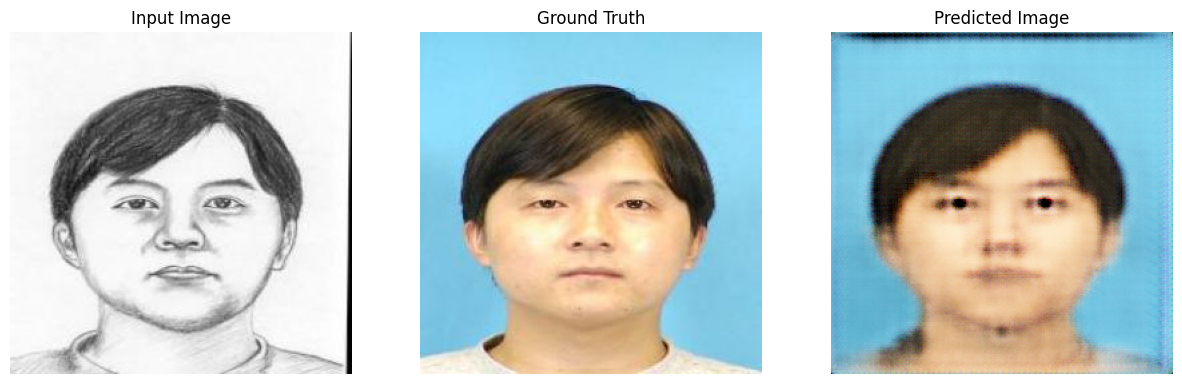

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


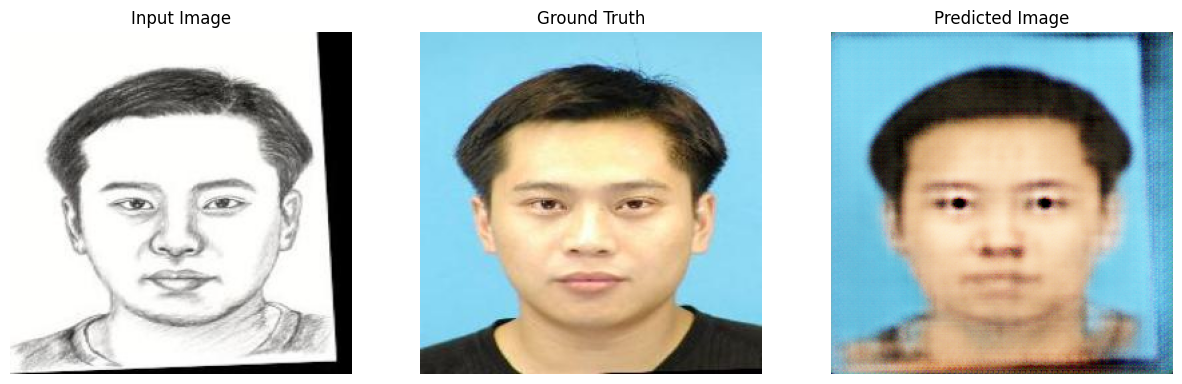

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


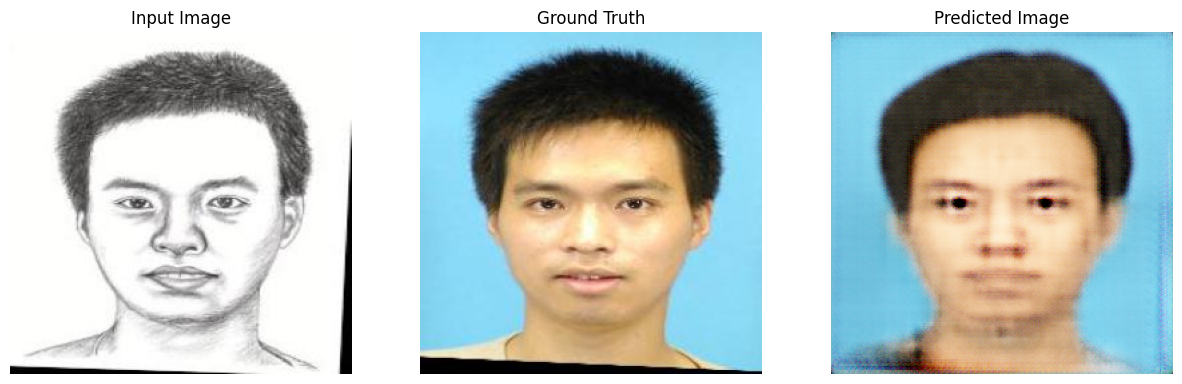

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


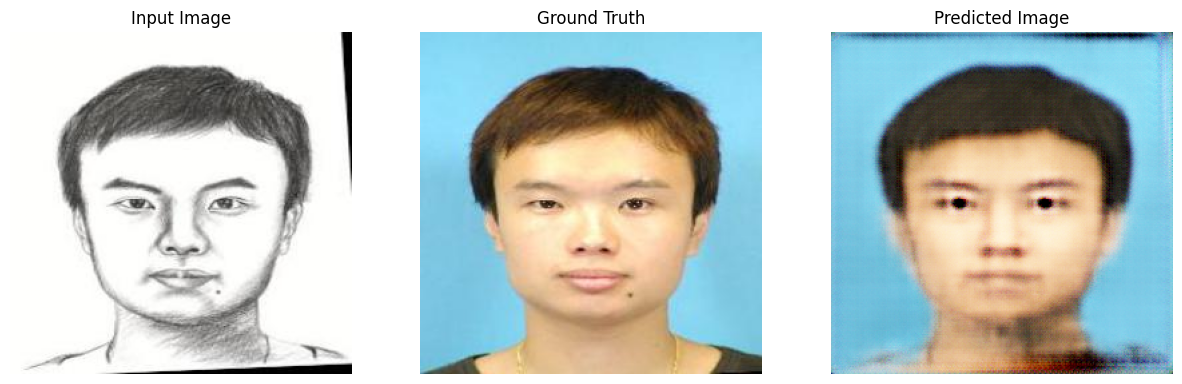

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


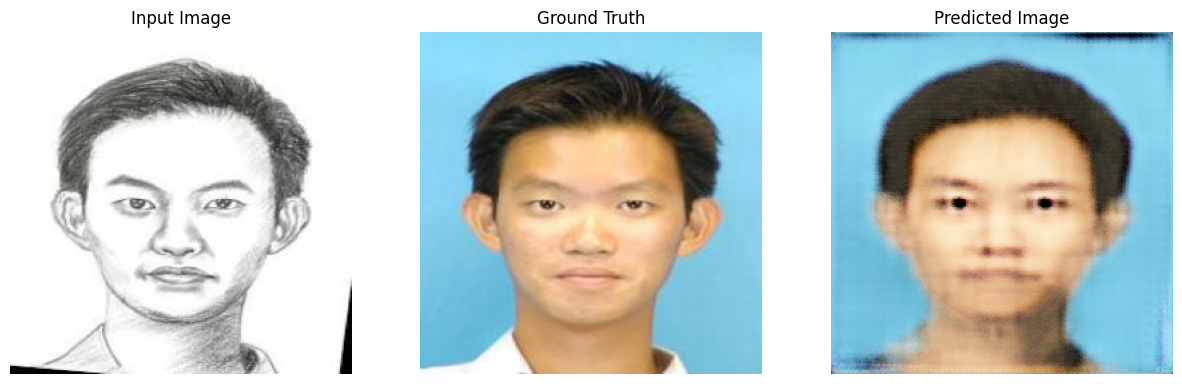

In [17]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((sketch_dataset_t,photo_dataset_t)).take(11):
  generate_images(generator, example_input, example_target)


In [18]:
generator.save('pix2pix_gan_50.h5')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [19]:
generator.save_weights('pix2pix_gan_weight_50.h5')

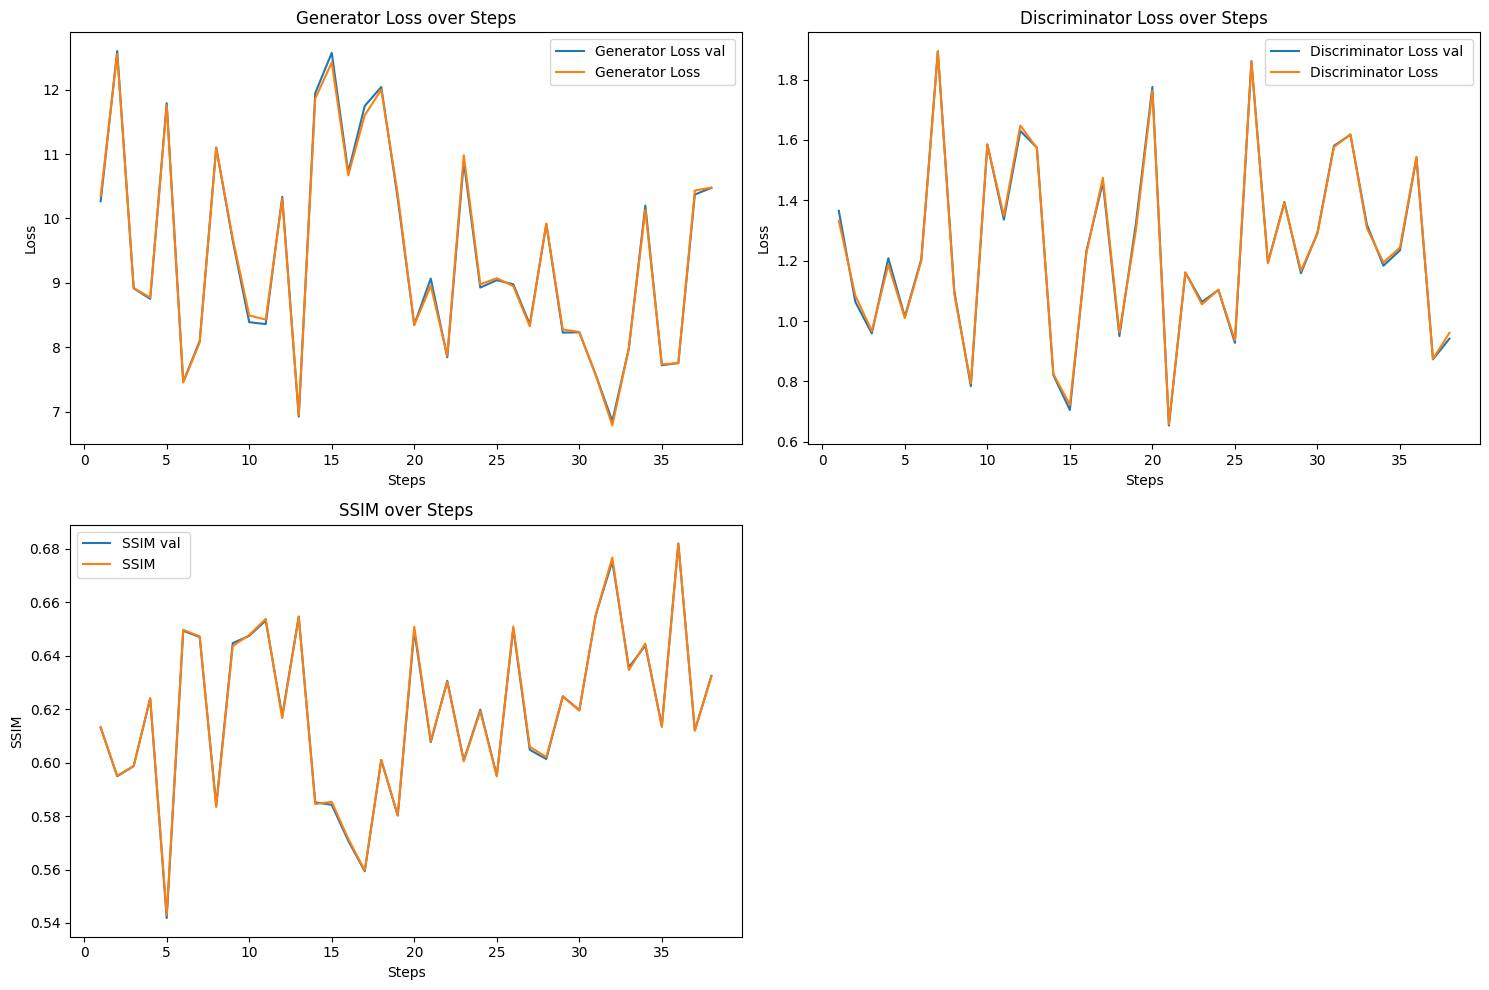

In [34]:
import matplotlib.pyplot as plt
epoch = 20 


# Separate the metrics for the test dataset
test_step_metrics = []

for (input_image, target) in zip(sketch_dataset_t, photo_dataset_t):
    gen_total_loss, disc_loss, ssim_ = test_step(input_image, target, epoch)
    test_step_metrics.append((gen_total_loss, disc_loss, ssim_))

# Create step numbers for plotting
steps_range_train = range(1, len(train_step_metrics) + 1)
steps_range_test = range(1, len(test_step_metrics) + 1)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)

plt.plot(steps_range_test, [metric[0] for metric in test_step_metrics], label='Generator Loss ')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Generator Loss over Steps')
plt.legend()

plt.subplot(2, 2, 2)

plt.plot(steps_range_test, [metric[1] for metric in test_step_metrics], label='Discriminator Loss ')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Discriminator Loss over Steps')
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(steps_range_test, [metric[2] for metric in test_step_metrics], label='SSIM ')
plt.xlabel('Steps')
plt.ylabel('SSIM')
plt.title('SSIM over Steps')
plt.legend()

plt.tight_layout()
plt.show()
